## EKF Imeplementation

This Notebook contains codes to implement Extended Kalman Filter on a JetBot.

In [136]:
import os
import pickle
import cv2
import numpy as np
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

from jetbot import bgr8_to_jpeg
from jetbot import ObjectDetector
from jetbot import Camera
from jetbot import Robot


In [137]:
model = ObjectDetector('../Notebooks/object_following/ssd_mobilenet_v2_coco.engine')
camera = Camera.instance(width=300, height=300)
robot = Robot()

Directories not created because they already exist


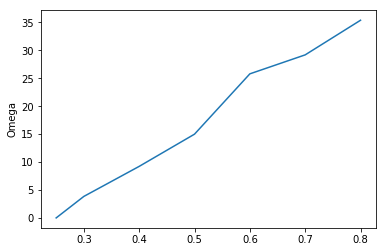

In [185]:
# Load COCO labels
filename = "coco_labels.dat"
filehandler = open(filename, 'rb')
COCO_labels = pickle.load(filehandler)

# Load camera calibration data for undistort
filename = "calibration.dat"
filehandler = open(filename, 'rb')
camera_cal = pickle.load(filehandler)
mtx = camera_cal['mtx']
dist = camera_cal['dist']
f_u = mtx[0,0]  # focal lengths in u pixels (image plane horizontal)
f_v = mtx[1,1]  # focal lengths in v pixels (image plane vertical)
c_u = mtx[0,2]  # focal center in u pixels (image plane horizontal)
c_v = mtx[1,2]  # focal center in v pixels (image plane vertical)
focal_center = np.array([c_u, c_v])

# Open Image Widget
image_widget = widgets.Image(format='jpeg', width=300, height=300)
width = int(image_widget.width)
height = int(image_widget.height)

BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

diag_dir = 'diagnostics'
# we have this "try/except" statement because these next functions can throw an error if the directories exist already
try:
    os.makedirs(diag_dir)
except FileExistsError:
    print('Directories not created because they already exist')

# Mapping between set_motor "speed" and measured wheel angular velocity "omega"
# for 0.1 second motor running time
wheel_calibration = {
    "speed": [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "omega": [0.0, 3.85, 9.23, 15.0, 25.8, 29.2, 35.4]
}

plt.plot(wheel_calibration["speed"],wheel_calibration["omega"])
plt.ylabel('Omega')
# fig = plt.figure(figsize=(4, 5))
plt.savefig('test.png')
plt.show()

In [328]:
def forward(wheel_speed, Rtime):

    robot.set_motors(wheel_speed, wheel_speed)
    time.sleep(Rtime)
    robot.stop()
    
    return

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def omega2speed(in_val, mapping, debug=False):
    """ Map wheel angular speed to motor speed setting based on a calibration mapping """
    
    if in_val < 0:
        sign = -1
        in_val = abs(in_val)
    else:
        sign = 1
        
    out_lower = 0
    in_lower = 0
    out_val = 0

    for i, in_upper in enumerate(mapping["omega"]):
        if debug:
            print (i, in_upper)
        if in_val < in_upper:
            out_upper = mapping["speed"][i]
            out_val = out_lower + (in_val - in_lower)/(in_upper - in_lower) \
                *(out_upper-out_lower)
            if debug:
                print("yes", out_val)
            break
        else:
            if debug:
                print("no")
            out_lower = mapping["speed"][i]
            in_lower = in_upper
            
    if out_val is 0:
        print ("Input is too high!!!", in_val)
        out_val = 0
        
    return sign*out_val


def calc_wheel_velocities(direction='L', arc_radius=0.5, min_ang_vel=3.85, \
       wheel_radius=0.0325, axle_length=0.12, debug = False):
    """ Calculate wheel velocities to generate forward arc motion of provided radius """

    radius = arc_radius
    axle = axle_length
    
    if direction is 'L':
        """ If left turn, angular velocity of right wheel should be higher.
        Set angular velocity of left wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        l_ang_vel = min_ang_vel
        r_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    else:
        """ If right turn, angular velocity of left wheel should be higher.
        Set angular velocity of right wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        r_ang_vel = min_ang_vel    
        l_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    
    if debug:
        print ("Left angular velocity:",l_ang_vel, " Right angular velocity:",r_ang_vel)
        T = control2robot(wheel_radius, axle_length)
        robot_velocities = np.dot(T, np.array([[r_ang_vel],[l_ang_vel]]))
        print ("Robot velocities:", robot_velocities)
        print("arc radius = ",abs(robot_velocities[0,0]/robot_velocities[1,0]))
    
    return np.array([[r_ang_vel],[l_ang_vel]])

def update_map(Mu, landmarks, debug=False):
    """ Update robot position on map """
    plt.xlim([0,180])
    plt.ylim([0,180])
    
    """ Display robot as line + triangle (arrow) """
    robot_x = Mu[0,0]*100
    robot_y = Mu[1,0]*100
    robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
    
    if debug:
        print("(x,y):{:.1f}, {:.1f}".format(robot_x,robot_y))
        print("Orientation: {:.1f}".format(Mu[2,0]*180/math.pi))
    
    # robot = line + triangle
    plt.plot(robot_x, robot_y, marker=(2, 0, robot_theta), c='k',markersize=15, linestyle='None')
    plt.plot(robot_x, robot_y, marker=(3, 0, robot_theta), c='k',markersize=10, linestyle='None')
    
    """ Display landmark as cross """
    for i, landmark in enumerate(landmarks):
        if landmark['observed'] is True:
            landmark_x = Mu[3+2*i]*100
            landmark_y = Mu[3+2*i+1]*100
            plt.plot(landmark_x, landmark_y,marker='x', markersize=12, color='green')
            plt.text(landmark_x, landmark_y+10, landmark["obj_name"])
    
    plt.show()
    return

def undistort(img, mtx, dist, crop=False):
    """Undistort camera image based on calibration data"""
    h,w = img.shape[:2]
    # print (h,w)
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image (optional)
    if crop:
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
    return dst

def draw_bbox(img, width, height, bbox, color, line_width):
    bbox_pixel = [(int(width * bbox[0]), int(height * bbox[1])), 
                  (int(width * bbox[2]), int(height * bbox[3]))]
    cv2.rectangle(img, bbox_pixel[0], bbox_pixel[1], color, line_width)
    return bbox_pixel

def display_landmarks(img, landmarks, width, height, debug=False):
    """ put blue bounding boxes on detected objects on image """
    
    for item in landmarks:
        label = COCO_labels[item['label']-1]
        bbox = item['bbox']
        bbox_pixel = draw_bbox(img, width, height, bbox, BLUE, 1)
        if debug:
            print(label,item['label'], bbox_pixel)
    return

def landmark_coordinates(item, width, height):
    """ calculate landmark's left, center and right in image pixel coordinates """
    u_left = item['bbox'][0] * width
    u_right = item['bbox'][2] * width
    u_center = (item['bbox'][0]+item['bbox'][2])*width/2
    return u_left, u_center, u_right


In [325]:
def take_circ_step(robot_params, direction, radius, debug=False, motion=True):
    
    # load robot control parameters
    start_x = robot_params["start_x"]
    start_y = robot_params["start_y"]
    wheel_radius = robot_params["wheel_radius"]
    axle_length = robot_params["axle_length"]
    motor_on_time = robot_params["motor_on_time"]
    motor_off_time = robot_params["motor_off_time"]
    min_ang_velocity = robot_params["min_ang_velocity"]
    
    """ Generate clamped wheel velocities based on turn direction and radius """
    wheel_velocities = calc_wheel_velocities(direction='L', arc_radius=radius, \
        min_ang_vel=min_ang_velocity, \
        wheel_radius=wheel_radius, axle_length=axle_length, debug = debug)
    
    """ Map wheel angular velocities to motor setting, then run motors """ 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
    if debug:
        print ("L motor:", w_l," R motor:", w_r)
    
    """ Run motor step motion """
    if motion:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)
    
    return wheel_velocities

In [337]:
robot_params = {
    # pose
    "start_x": 1.0,
    "start_y": 1.0,
    "start_theta": math.pi/2,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.0, # Equivalent to motor speed setting of 0.3
    "focal_length": 0.00315 # camera focal lenght in meter
}

control_params = {
    "num_iter": 11,
    "interval": 10,
    "debug": False,
}

landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False
    },
    {
    "label": 47,
    "obj_name": 'cup',
    "width": 0.12,
    "observed": False
    }
]

landmark_item_list = []
for item in landmarks:
    landmark_item_list.append(item['label'])
  

(x,y):100.0, 100.0
Orientation: 90.0


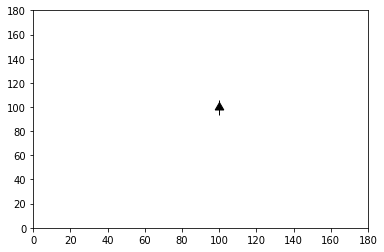

(dx,dy,dtheta):-0.00,0.02,0.06
horse (left,center, right):182.8,237.6,                 292.4
horse estimated phi:-28.39428 degree
horse estimated range:51.4cm
Mu: [[0.99934]
 [1.02293]
 [1.62815]
 [1.21741]
 [1.4886 ]
 [0.     ]
 [0.     ]]
cup (left,center, right):29.6,75.7,                 121.9
cup estimated phi:19.41306 degree
cup estimated range:21.4cm
Mu: [[0.99934]
 [1.02293]
 [1.62815]
 [1.21741]
 [1.4886 ]
 [0.91678]
 [1.22041]]
(x,y):99.9, 102.3
Orientation: 93.3


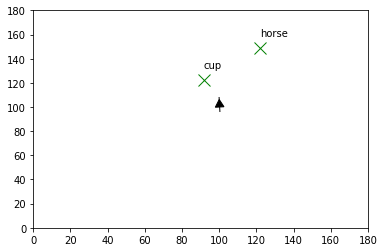

(dx,dy,dtheta):-0.00,0.02,0.06
horse (left,center, right):182.1,238.4,                 294.8
horse estimated phi:-28.52161 degree
horse estimated range:50.3cm
Mu: [[0.99737]
 [1.04578]
 [1.6855 ]
 [1.21741]
 [1.4886 ]
 [0.91678]
 [1.22041]]
cup (left,center, right):29.7,73.9,                 118.1
cup estimated phi:20.11410 degree
cup estimated range:22.2cm
Mu: [[0.99737]
 [1.04578]
 [1.6855 ]
 [1.21741]
 [1.4886 ]
 [0.91678]
 [1.22041]]
(dx,dy,dtheta):-0.00,0.02,0.06
horse (left,center, right):182.8,234.7,                 286.6
horse estimated phi:-27.77141 degree
horse estimated range:53.6cm
Mu: [[0.99409]
 [1.06848]
 [1.74286]
 [1.21741]
 [1.4886 ]
 [0.91678]
 [1.22041]]
cup (left,center, right):32.6,76.5,                 120.5
cup estimated phi:19.49058 degree
cup estimated range:22.2cm
Mu: [[0.99409]
 [1.06848]
 [1.74286]
 [1.21741]
 [1.4886 ]
 [0.91678]
 [1.22041]]
(dx,dy,dtheta):-0.00,0.02,0.06
cup (left,center, right):32.1,77.0,                 121.9
cup estimated phi:19.26321 

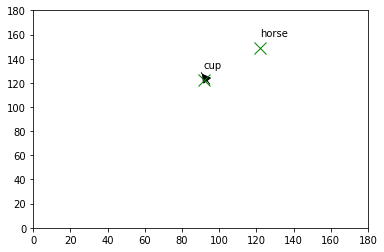

In [338]:
# Display camera image with bounding boxes for detected objects
display(widgets.HBox([image_widget]))

LARGE = 1e6
t_delta = 0.1  # motor on time
dt = 0.1
R_t = np.zeros((3,3))  # Assume zero control noise for now

diag_dir = 'diagnostics'

debug = False
np.set_printoptions(precision=5)

focal_length = robot_params["focal_length"]
correct_factor = 0.769
camera_offset = robot_params["camera_offset"]

wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
T = control2robot(wheel_radius,axle_length)

# robot's initial pose
x = robot_params["start_x"]
y = robot_params["start_y"]
theta = robot_params["start_theta"]

# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]

""" Initialize Mu and Sigma """
# Initialize Mu
Mu = np.array([[x],[y],[theta]])
for object in range(len(landmark_item_list)):
    Mu = np.vstack((Mu,np.array([[0],[0]])))
N = Mu.shape[0]   # N=3+2n, n=num of landmarks

# Initialize Sigma - For Σ_mm, infinity (large num) along the diagonal and zero everywhere else 
Sigma = np.zeros((N,N))
Sigma[3:,3:] = np.eye(N-3)*LARGE

if debug:
    print(Mu)
    print(Sigma)

# Place robot (and landmark)on map
update_map(Mu, landmarks, debug=True)

""" Robot moves stepwise in a circle """
for i in range(num_iter):
    
    """ Move robot """
    # Take 1 circular step
    wheel_velocities = take_circ_step(robot_params, 'L', 0.4, debug=False, motion=False)
    robot_velocities = np.dot(T,wheel_velocities)   # convert to (v,omega)

    if debug:
        print("Step: ", i+1)
        print("(w_r,w_l): {}".format(wheel_velocities))
        print("(v,omega): {}".format(robot_velocities))
        
    """ EKF Prediction Step """
    v = robot_velocities[0,0]
    w = robot_velocities[1,0]
    arc_radius = v/w   # arc radius 
    
    """
    x_delta = v*t_delta*math.cos(theta)
    y_delta = v*t_delta*math.sin(theta)
    """
    theta = Mu[2,0]
    x_delta = arc_radius*(math.sin(theta+w*t_delta)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*t_delta))
    theta_delta = w*t_delta

    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)

    # Implement Mu_t = g(Mu_t-1, u_t) 
    Mu = Mu + np.dot(F.T, np.array([[x_delta],[y_delta],[theta_delta]]))

    # Calculate G_t
    d_x_delta = arc_radius*(math.cos(theta+w*t_delta)-math.cos(theta))
    d_y_delta = arc_radius*(-math.sin(theta)+math.sin(theta+w*t_delta))
    G_x_t = np.array([[0,0,d_x_delta],[0,0,d_y_delta],[0,0,0]])
    G_t = np.eye(N)+ np.dot(np.dot(F.T, G_x_t),F)

    # Calculate Sigma_t = G_t.Sigma_t-1.G_t^T + F^T.R_t.F
    Sigma = np.dot(np.dot(G_t, Sigma),G_t.T) + np.dot(np.dot(F.T, R_t),F)
    
    print("(dx,dy,dtheta):{:.2f},{:.2f},{:.2f}".format(x_delta,y_delta,theta_delta))
    if debug:
        print("(dx,dy,dtheta):{:.2f},{:.2f},{:.2f}".format(x_delta,y_delta,theta_delta))
        print("Mu:",Mu)
        np.set_printoptions(suppress=True)
        print("G:",G_t)
        print("Sigma:",Sigma)
    
    """ Grab camera image, undistort and detect objects """
    image = undistort(camera.value, mtx, dist) # undistort camera image
    detections = model(image) # Use SSD model to detect objects
    
    """ Identify landmarks and estimate range(r)/bearing(phi) from robot """
    items = []
    for object in detections[0]:
        
        coco_id = object['label']
        if coco_id in landmark_item_list:
            # calculate landmark's left, center and right image pixel coordinates
            u_l, u_c, u_r = landmark_coordinates(object, width, height)
            
            """ Estimate landmark range (r) and bearing (phi) """
            j = landmark_item_list.index(coco_id)
            landmark_width = landmarks[j]['width']
            phi = math.atan2(c_u-u_c, f_u) # phi is +ve if landmark is left of focal center
            depth = f_u/(u_r-u_l)*landmark_width*correct_factor-focal_length
            r = depth/math.cos(phi)
            
            true_phi = math.atan2(r*math.sin(phi), depth+focal_length+camera_offset)
            true_r = (depth+focal_length+camera_offset)/math.cos(true_phi)
            
            """ If previously unobserved, update (Mu_j_x, Mu_j_y) """
            if landmarks[j]['observed'] is False:
                landmarks[j]['observed'] = True
                Mu[3+2*j,0] = Mu[0,0] + true_r*math.cos(true_phi+Mu[2,0])
                Mu[3+2*j+1,0] = Mu[1,0] + true_r*math.sin(true_phi+Mu[2,0])
            else:
                continue
            
            
            if True:
                print("{} (left,center, right):{:.1f},{:.1f}, \
                {:.1f}".format(COCO_labels[coco_id-1], u_l, u_c, u_r))
                print("{} estimated phi:{:.5f} degree".format(COCO_labels[coco_id-1],true_phi/3.14*180))
                print("{} estimated range:{:.1f}cm".format(COCO_labels[coco_id-1],true_r*100)) 
                print("Mu:", Mu)
            items.append(object)  # save item to display bounding box in image
            
    # Update robot and landmark on map
    if i%interval==0:
        update_map(Mu, landmarks, debug=True)
    
    cv2.line(image,(int(c_u),0),(int(c_u),300),GREEN,1)        
    display_landmarks(image, items, width, height, debug) # put bounding boxes on detected objects
    image_widget.value = bgr8_to_jpeg(image)  # update image widget with camera image
    

In [332]:
# Make approx 3 to 4 circular runs - 300 steps
for i in range(3):
    take_circ_step(robot_params, 'L', 0.5, debug=False)

In [333]:
robot.stop()

In [334]:
landmarks[0]["obj_name"]

'horse'

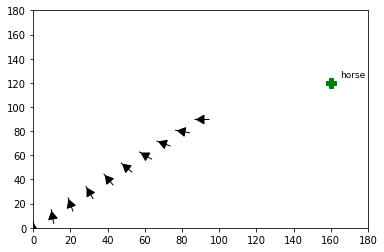

In [335]:
x = [0,10,20,30,40,50,60,70,80,90]

for i in x:
    plt.plot(i, i, marker=(2, 0, i), c='k',markersize=15, linestyle='None')
    plt.plot(i, i, marker=(3, 0, i), c='k',markersize=10, linestyle='None')

plt.plot(160, 120, marker='P', markersize=10, color='green', )
plt.text(165, 125, "horse", fontsize=9)

plt.xlim([0,180])
plt.ylim([0,180])

plt.show()


In [336]:
for i in range(18):
    theta = math.pi/(18-i+1)
    print(theta, math.sin(theta+0.057353)-math.sin(theta))

0.16534698176788384 0.05626913948353665
0.17453292519943295 0.05616520134464176
0.18479956785822313 0.056043427196913076
0.19634954084936207 0.055899371057812786
0.20943951023931953 0.055727093825776924
0.2243994752564138 0.05551851525397622
0.241660973353061 0.05526241163181744
0.2617993877991494 0.05494281908848597
0.28559933214452665 0.05453640277956778
0.3141592653589793 0.05400794990310209
0.3490658503988659 0.053302288803685705
0.39269908169872414 0.05232899797089824
0.4487989505128276 0.05093153766428349
0.5235987755982988 0.048819813189689254
0.6283185307179586 0.04540766271047081
0.7853981633974483 0.03936981770057113
1.0471975511965976 0.027236834196859072
1.5707963267948966 -0.0016442325233999577
